# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Basic Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                  np.cos(season_time * 6 * np.pi),
                  2 / np.exp(9 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [5]:
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10

series = trend(time, 0.1)  
period = 365
amplitude = 40
slope = 0.005
noise_level = 3

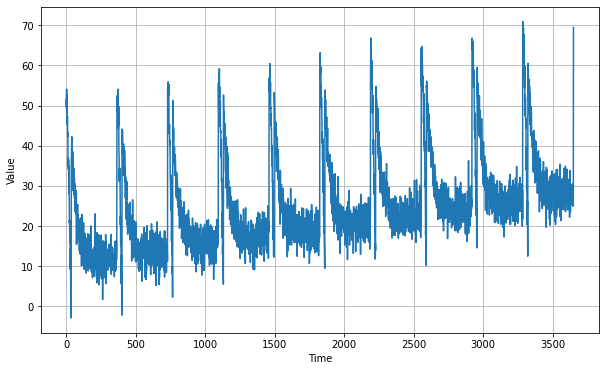

In [6]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting

In [7]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [20]:
len(time_train), len(time_valid)

(3000, 651)

In [19]:
len(x_train), len(x_valid)

(3000, 651)

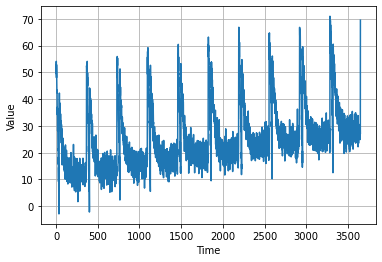

In [8]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_time_series(time, series)

# Windowed Dataset

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

for x,y in dataset:
  print(x.numpy(), y.numpy())
  break

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
[[13.722229   9.255733   8.597066  13.240248  11.106062  13.902592
  13.164951  11.511896   9.175629   7.1575675 10.349124  14.244875
  12.305408   7.9137836 12.158834  12.783943   8.965514  12.067744
  11.771057   8.157749 ]
 [14.48123    9.753934  16.283813  12.961496  11.952518  16.67221
  11.41666    9.308827   8.868857  15.361317   9.706554  18.81679
   7.311196  18.65094   14.19922   13.280634  11.940631  14.777422
  13.471744  16.899197 ]
 [37.281612  33.42388   38.894012  37.480774  30.98306   34.171803
  32.73199   34.45189   27.012438  31.53738   32.23706   23.378422
  24.707752  21.75252   26.684235  29.276646  31.271746  26.636492
  30.958244  21.598728 ]
 [10.349124  14.244875  12.305408   7.9137836 12.158834  12.783943
   8.965514  12.067744  11.771057   8.157749  12.650612  13.250545
  14.808627  14.712497   7.4100256  8.721819  13.072971  13.062098
  13.0590515 23.065561 ]
 [12.283473  18

# Creating a Model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mse", 
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
    )

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(dataset,
          epochs=100)

Epoch 1/100
94/94 [==============================] - 1s 5ms/step - loss: 72.5481
Epoch 2/100
94/94 [==============================] - 1s 4ms/step - loss: 33.0673
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 29.3731
Epoch 4/100
94/94 [==============================] - 1s 5ms/step - loss: 27.4490
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 26.6106
Epoch 6/100
94/94 [==============================] - 1s 4ms/step - loss: 25.3076
Epoch 7/100
94/94 [==============================] - 1s 5ms/step - loss: 24.7423
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 24.3685
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 24.1448
Epoch 10/100
94/94 [==============================] - 0s 4ms/step - loss: 23.5368
Epoch 11/100
94/94 [==============================] - 0s 4ms/step - loss: 23.3278
Epoch 12/100
94/94 [==============================] - 0s 4ms/step - loss: 23.3104
Epoch 13/100
94/94 [=====

# Forecast

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

print(len(results))


651


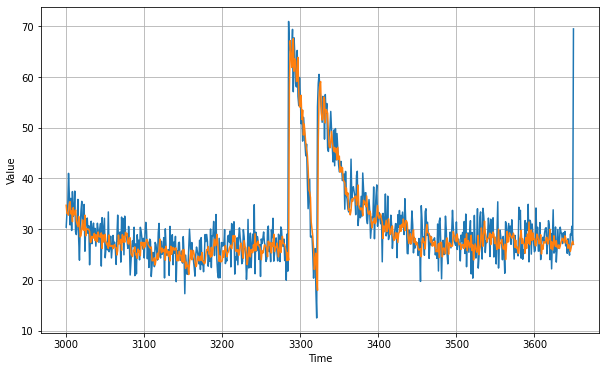

In [15]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0738907